In [3]:
import os
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning import Trainer, seed_everything
import matplotlib.pyplot as plt

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [5]:
import seqrep.datasets as dset
from seqrep.models.lightning import SGNS

In [6]:
seed_everything(7);

## Data

In [103]:
%%time

variant = 'lastfm-50'

lastfm_dataset = dset.LastFMUserItemDataset(
    variant, min_item_cnt_thresh=16, max_sequence_length=1000, max_window_size_lr=5)

CPU times: user 1.15 s, sys: 162 ms, total: 1.32 s
Wall time: 1.32 s


In [104]:
lastfm_dataset.df.shape

(720525, 7)

In [96]:
lastfm_dataset.df.sample(3)

,user_id,timestamp,artist_id,artist_name,track_id,track_name,artist_cd
62282,user_000021,2007-12-26 21:00:06+00:00,c42ec991-7cb6-43a7-96d3-41852036f7f7,Youth Brigade,2e7e0337-66fa-43c7-862b-188b7b0cc867,Live Life,8620
346747,user_000343,2006-07-14 18:56:10+00:00,c0b2500e-0cef-4130-869d-732b23ed9df5,Tori Amos,6548155c-2562-426e-aa45-0b9dc6fcaa8b,Time,8094
674226,user_000788,2008-05-31 09:03:31+00:00,837555ba-012e-45f1-9a9c-9628da13ee54,Ben E. King,5d607145-9fbe-4116-9bd0-6f10121c3b3e,I Who Have Nothing,782


In [9]:
lastfm_dataset.df.artist_cd.nunique()

6237

In [10]:
lastfm_dataset.df.groupby('user_id').size().describe()

count       50.000000
mean     14771.460000
std      17203.018493
min          8.000000
25%       2863.500000
50%       9333.500000
75%      18405.750000
max      73440.000000
dtype: float64

In [102]:
lastfm_dataset.df.groupby('artist_id').size().describe()

count     5829.000000
mean       122.667524
std        483.887588
min          1.000000
25%         16.000000
50%         32.000000
75%         93.000000
max      25116.000000
dtype: float64

In [82]:
def item_frequencies(df, item_col):
    item_cnts = df[item_col].value_counts()
    total = item_cnts.sum()
    item_freq = (item_cnts / total).sort_index()
    return item_freq

def subsample(df, item_col, thresh=1e-5):
    item_freq = item_frequencies(df, item_col)
    discard_dist = (1 - np.sqrt(thresh/item_freq))
    subsampled = discard_dist.loc[(1 - discard_dist) > np.random.random(size=len(discard_dist))]
    return subsampled.index.tolist()

def item_distribution(df, item_col, p=0.75):
    item_freq = item_frequencies(df, item_col)
    item_dist = (item_freq**(p))/np.sum(item_freq**(p))
    return item_dist

In [89]:
items = subsample(lastfm_dataset.df, item_col='artist_cd', thresh=1e-3)
print(len(items))
items[:10]

5565


[1, 3, 4, 5, 6, 7, 8, 9, 10, 11]

1.0


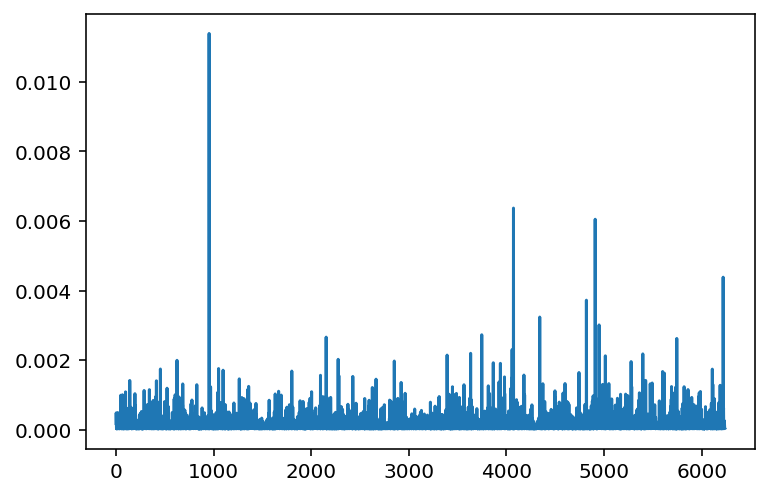

In [94]:
item_dist = item_distribution(lastfm_dataset.df, item_col='artist_cd', p=-0.5)
print(item_dist.sum())
plt.plot(item_dist);

In [7]:
lastfm_dataloader = DataLoader(lastfm_dataset, batch_size=32, num_workers=6, drop_last=True)

In [8]:
model = SGNS(
    num_embeddings=lastfm_dataset.num_items, embedding_dim=128,
    weights=item_dist, num_negative_samples=20, nn_embedding_kwargs={'sparse': True},
    learning_rate=0.003
)

## Training

In [9]:
tb_logger = pl_loggers.TensorBoardLogger('logs/', name=f'sgns-{variant}')

### Dry Run

In [10]:
trainer = Trainer(logger=tb_logger, fast_dev_run=True)

Running in fast_dev_run mode: will run a full train, val and test loop using a single batch
GPU available: False, used: False
TPU available: False, using: 0 TPU cores


In [11]:
trainer.fit(model, train_dataloader=lastfm_dataloader)


  | Name              | Type      | Params
------------------------------------------------
0 | embeddings        | Embedding | 623 K 
1 | target_embeddings | Embedding | 623 K 


1

### Train

In [12]:
trainer = Trainer(logger=tb_logger, max_epochs=3, progress_bar_refresh_rate=100)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


In [13]:
trainer.fit(model, train_dataloader=lastfm_dataloader)


  | Name              | Type      | Params
------------------------------------------------
0 | embeddings        | Embedding | 623 K 
1 | target_embeddings | Embedding | 623 K 


1

In [14]:
lu = lastfm_dataset.id_metadata
len(lu)

6237

In [15]:
embeddings = model.embeddings.weight.detach().cpu().numpy()
embeddings.shape

(6237, 100)

In [16]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [34]:
num_embeddings = 1000
rand_embedding_ids = np.random.randint(0, len(embeddings), num_embeddings)
tsne = TSNE()
embeddings_reduced = tsne.fit_transform(embeddings[rand_embedding_ids, :])
embeddings_reduced.shape

(1000, 2)

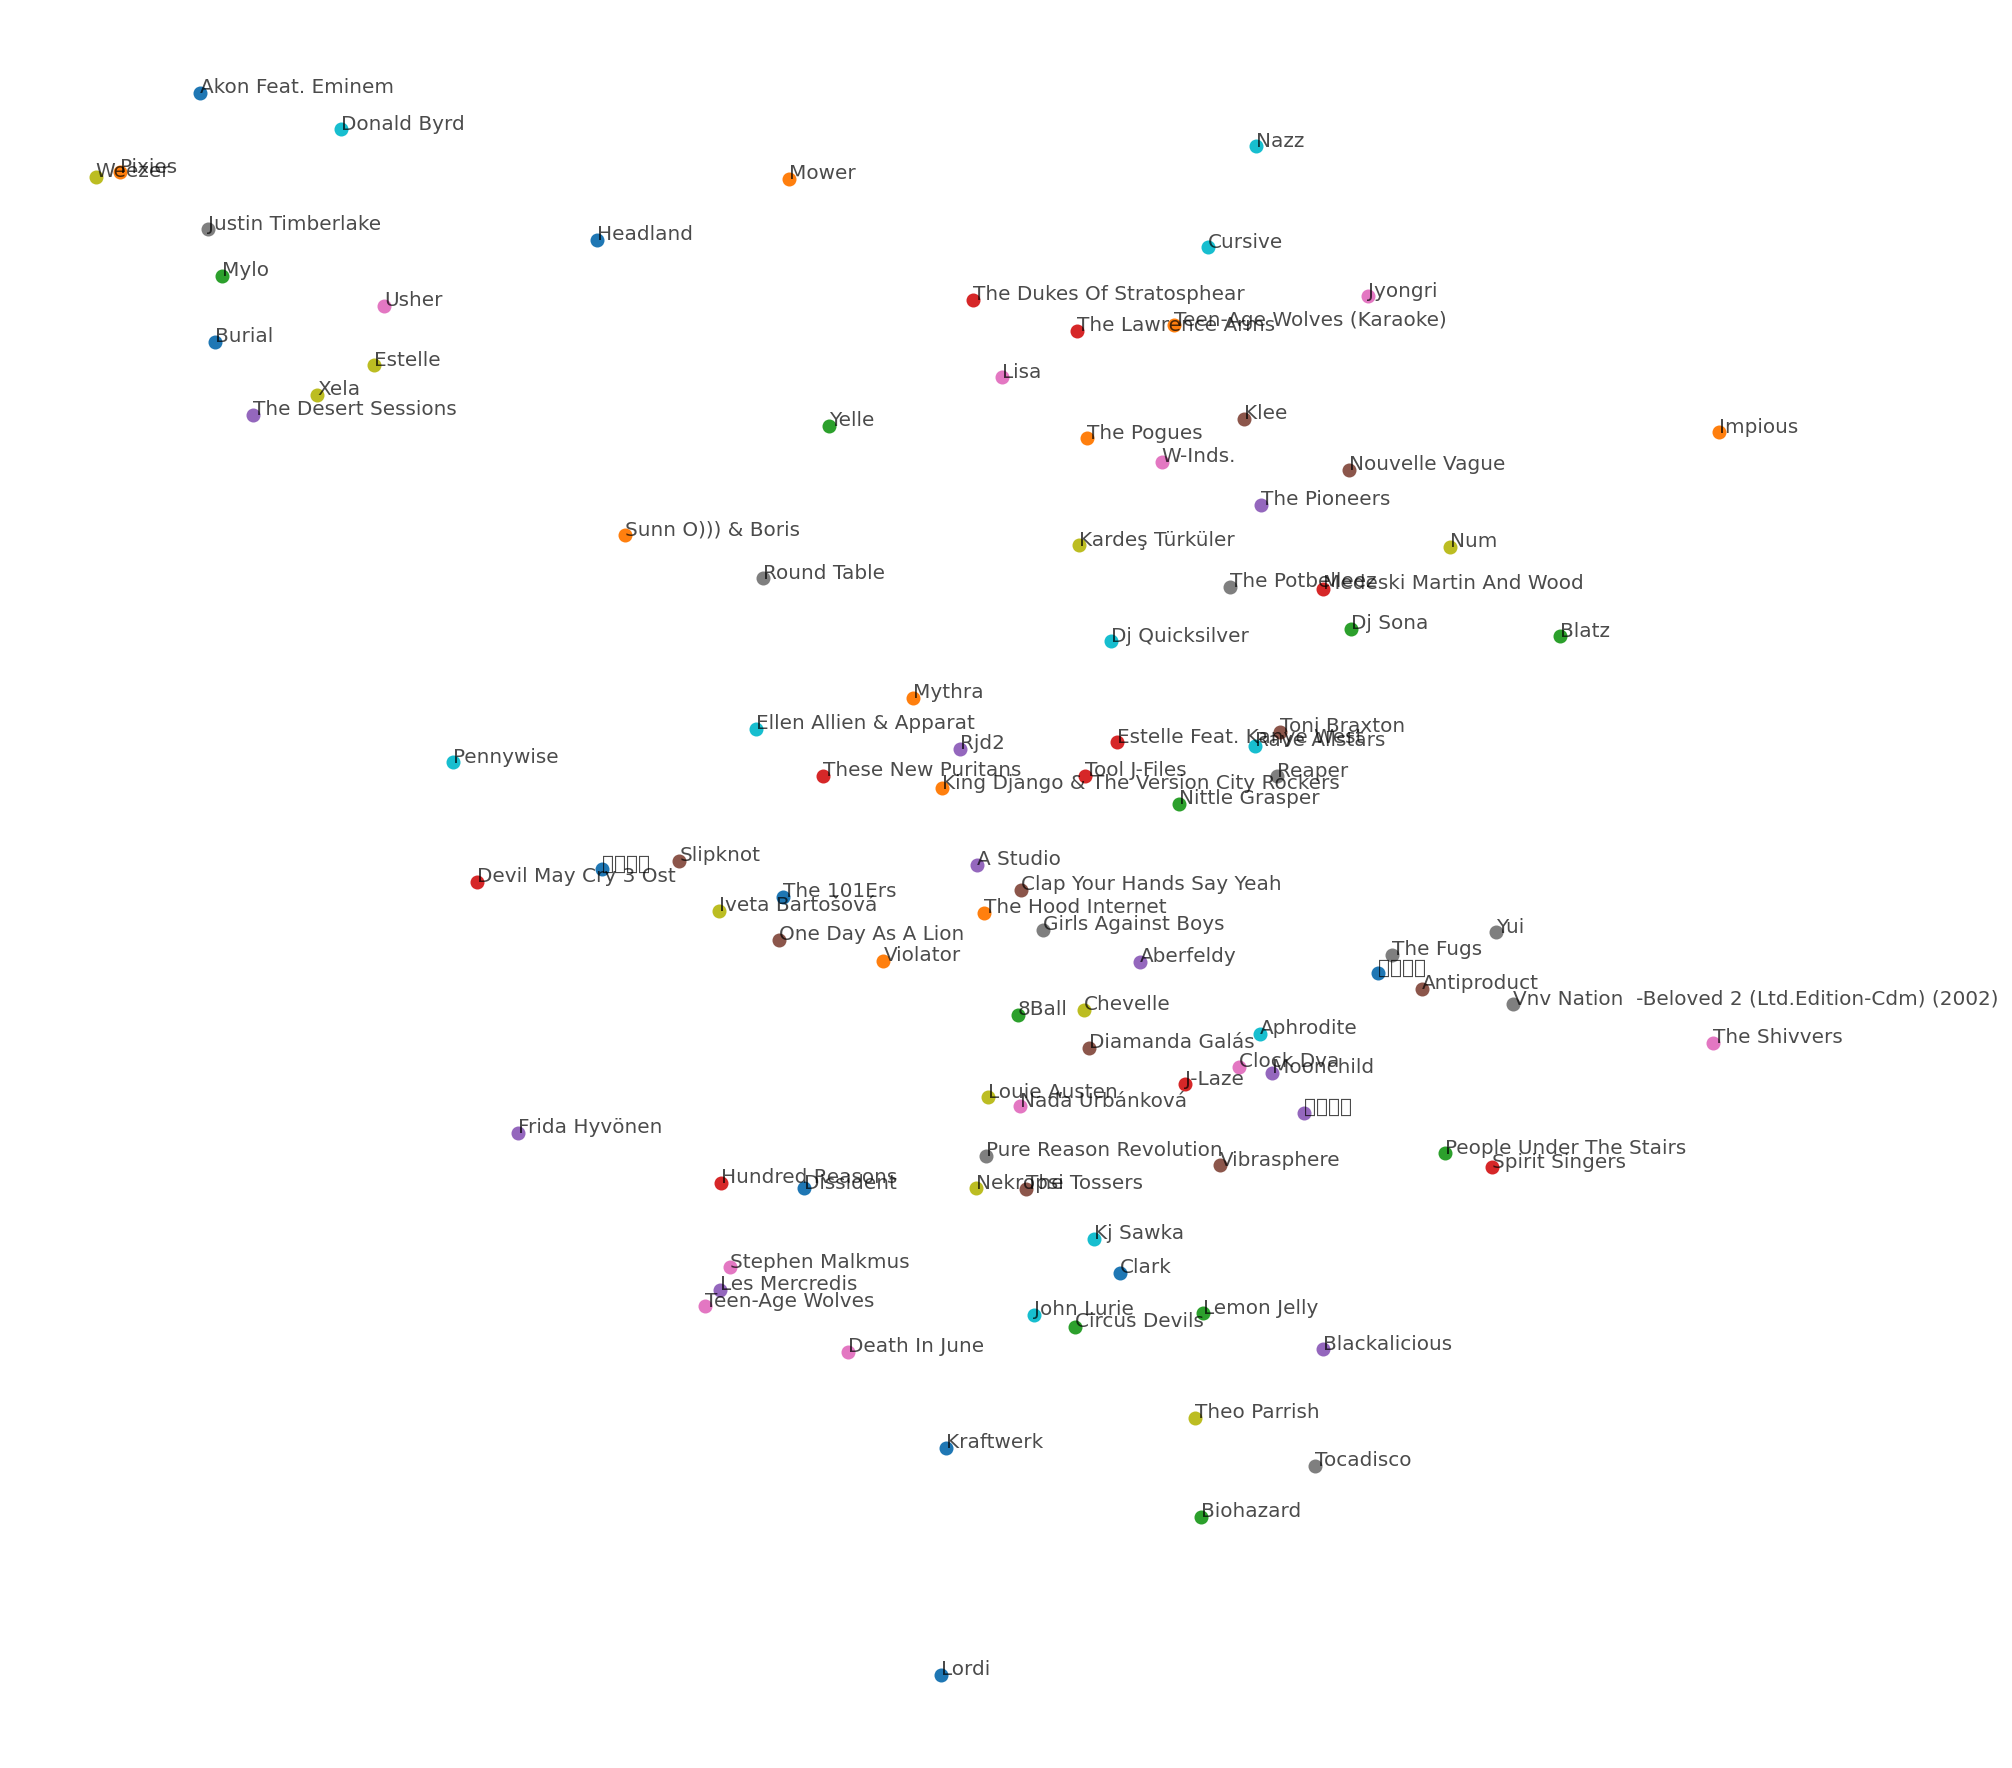

In [36]:
fig, ax = plt.subplots(figsize=(16, 16))
for i, embedding_id in enumerate(rand_embedding_ids):
    if (i+1) % 10 == 0:
        try:
            plt.scatter(embeddings_reduced[i, 0], embeddings_reduced[i, 1])
            plt.annotate(lu[embedding_id], (embeddings_reduced[i, 0], embeddings_reduced[i, 1]), alpha=0.7)
        except:
            pass
plt.axis('off');